# PROCESAMIENTO Y CLASIFICACIÓN DE SEÑALES EEG

In [1]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from scipy.fft import fft
import joblib

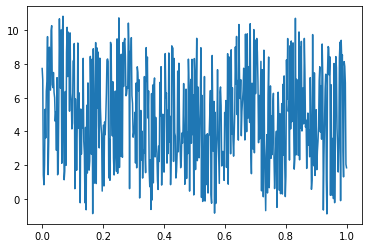

In [2]:
# Crearemos una señal de entrada
fm = 512
t = [np.arange(0,(1 + 1/fm),1/fm)]

signal = 1*np.sin(2*np.pi*5.*t[0]) + 10* np.random.rand(1,len(t[0]))
#print(np.shape(t), np.shape(senal))
#print(senal)

plt.figure()
plt.plot(t[0],signal[0])
plt.show()

## Calculo del espectro de la señal
Creamos la función para calcular el espectro de la señal de entrada entre 8 y 32Hz con una resolución de 2Hz

In [3]:
def nextpow2(i):
    n = 1
    while n < i: n *= 2
    return n

In [4]:
def get_spectrum(signal, fm):
    temp_data = []
    temp_F = []

    L = np.shape(signal)[1] 

    NFFT = fm # Longitud del dominio de la señal
    #NFFT2 = nextpow2(fm)

    temp_F = (fm/2)*np.linspace(0,1,int(NFFT/2+1)) # Generamos un vector que vaya de 0 hasta la mitad de la frecuencia de muestreo porque así serán las frecuencias que devolvera la FFT. Recordamos que es fm/2 por el th de Nyquist
    aux = fft(x= signal,n = NFFT,axis = 1)/L # aux tendrá el mismo tamaño que la señal, se transforman los datos con las transformada rápida de Fourier
    
    for i in range(np.shape(signal)[0]):
        real_part = abs(aux[i,0:int(np.shape(aux)[1]/2+1)]) # Cogemos la parte real de la mitad de la señal (la mitad por la frecuencia de Nyquist para que no se produzca aliesing)
        real_part2 = list(map(lambda x:x**2, real_part))
        temp_data.append(real_part2)
    
    output_temp = []
    
    """
    for i in range(int(np.argwhere(temp_F==8)[0,0]),int(np.argwhere(temp_F==32)[0,0])):
        output_temp.append(temp_data[0][i])
    """   
    temp_data_a = np.array(temp_data) 
    limit_left = int(np.argwhere(temp_F==8)[0,0])
    limit_right = int(np.argwhere(temp_F==32)[0,0])

    output_temp = temp_data_a[:,limit_left:limit_right]
        
    """
    for i in range(int(np.argwhere(temp_F==8)[0,0]),int(np.argwhere(temp_F==32)[0,0])):
        ot = []
        for j in range(np.shape(temp_data)[0]):
            ot.append(temp_data[j][i])
        output_temp.append(ot)
    """
        
    
    output = np.empty((np.shape(output_temp)[0],int(np.shape(output_temp)[1]/2)))
    
    count = 0
    for i in range(0, 23, 2):
        #output.append(output_temp[:,i]+output_temp[:,i+1])
        output[:,count] = (output_temp[:,i]+output_temp[:,i+1])
        count +=1
    
    output = np.transpose(output)
    output = np.reshape(np.transpose(output),-1)
    return output

In [5]:
output = get_spectrum(signal,fm)

In [6]:
print(output, len(output))

[0.06293249 0.0302988  0.03359362 0.03858872 0.0355414  0.02786848
 0.02729293 0.01799377 0.02654625 0.00945536 0.017379   0.02315741] 12


In [7]:
x = np.arange(8,32,2)
print(x, len(x))


[ 8 10 12 14 16 18 20 22 24 26 28 30] 12


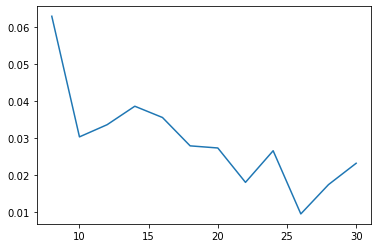

In [8]:
plt.plot(x,output)

# Procesamiento

Usaremos los registros EEG para trocearlos en ventanas y obtener sus características y su etiqueta correspondiente. Básicamente cogeremos y para cada ventana sacaremos su espectro de frecuencia entre 8 y 32Hz con una resolución de 2Hz

In [9]:
class RSession:
    def __init__(self,conf,data,task,complete,time):
        self.conf = conf
        self.data = data
        self.task = task 
        self.complete = complete
        self.time = time
        
class RConfig:
    def __init__(self,fm,description,electrodes_configuration, device, device_configuration_code, user_code, 
                 num_channels, electrode_positions_x, electrode_positions_y, electrode_names, register_code, 
                 samples_register, tasks, file_name):
        self.fm= fm
        self.description = description
        self.electrodes_configuration = electrodes_configuration
        self.device = device
        self.device_configuration_code = device_configuration_code
        self.user_code = user_code
        self.num_channels = num_channels
        self.electrode_positions_x = electrode_positions_x
        self.electrode_positions_y = electrode_positions_y
        self.electrode_names = electrode_names
        self.register_code = register_code
        self.samples_register = samples_register
        self.tasks = tasks
        self.file_name = file_name
class RTime:
    def __init__(self,register_date_start, register_date_stop):
        self.register_date_start = register_date_start
        self.register_date_stop = register_date_stop
        
class RTasks:
    def __init__(self,tasks_list,tasks_names):
        self.tasks_list = tasks_list
        self.tasks_names = tasks_names
        

In [10]:
import scipy.io as sio
def read_record(rec):
    ''' read_record('./RegistrosSinProcesar/user#0091#20040101#01#reg001.mat')'''
    mat = sio.loadmat(rec)
    #var = sio.whosmat('./RegistrosSinProcesar/user#0091#20040101#01#reg001.mat')
    #print(var, type(mat))
    #print(mat)

    mdata = mat['session']
    val = mdata[0,0]

    tasks_names_ar = []
    for j in range(len(val["conf"]["tasks"][0,0][0][0][1][0])):
        tasks_names_ar.append(val["conf"]["tasks"][0,0][0][0][1][0][j][0])
    r_tasks = RTasks(val["conf"]["tasks"][0,0][0][0][0][0],tasks_names_ar)
    electrode_names_ar = []
    for i in range(len(val["conf"]["electrode_names"][0,0][0])):
        electrode_names_ar.append(val["conf"]["electrode_names"][0,0][0] [i][0][0][0])
    conf = RConfig(val["conf"]["fm"][0,0][0][0], # int
                   val["conf"]["description"][0,0][0], #string
                   val["conf"]["electrodes_configuration"][0,0][0][0], #int
                   val["conf"]["device"][0,0][0], #string
                   val["conf"]["device_configuration_code"][0,0][0][0],#int
                   val["conf"]["user_code"][0,0][0][0],#int
                   val["conf"]["num_channels"][0,0][0][0],#int
                   val["conf"]["electrode_positions_x"][0,0][0], # array
                   val["conf"]["electrode_positions_y"][0,0][0],  # array
                   electrode_names_ar, # array
                   val["conf"]["register_code"][0,0][0][0],#int
                   val["conf"]["samples_register"][0,0][0][0],#int
                   r_tasks, #tasks object
                   val["conf"]["file_name"][0,0][0]) #string
    time = RTime(val["time"]["register_date_start"][0,0][0],val["time"]["register_date_stop"][0,0][0])

    rsession = RSession(conf, val["data"], val["task"][0], val["complete"][0,0], time)
    return rsession

In [11]:
rsession = read_record('./RegistrosSinProcesar/user#0091#20040101#01#reg001.mat')
print(rsession.conf.tasks.tasks_names)

['Generation of words beginning with the same random letter', 'Imagination of repetitive self-paced right hand movements', 'Imagination of repetitive self-paced left hand movements']


In [12]:
rsession.data[7]

array([6104.5356, 6113.7543, 6134.6605, ..., 6205.5667, 6200.1917,
       6211.3791])

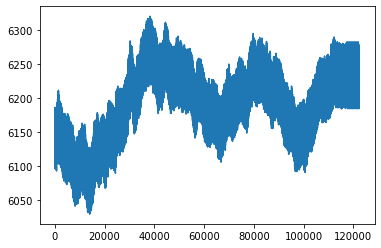

In [13]:
plt.figure()
plt.plot(rsession.data[7])
plt.show()

In [14]:
def get_index_electrodes(session, electrodes_name):
    electrodes_index = []
    for e in electrodes_name:
        index = np.argwhere(np.char.upper(np.array(session.conf.electrode_names))==np.char.upper(e))[0][0]
        #print(index)
        electrodes_index.append(index)
    return electrodes_index

In [15]:
def get_data_electrodes(session, electrodes_name):
    #print(session.conf.electrode_names)
    electrodes_index = get_index_electrodes(session, electrodes_name)
    #print(session.data[electrodes_index ,:])
    return session.data[electrodes_index ,:]

In [16]:
def eeg_processing(session, electrodes_name):
    # electrodes = [8 32 23 9 22 12 13 19]; # C3, Cz, C4, CP1, CP2, P3, Pz, and P4
    # electrodes_name = ["C3"]
    signal = get_data_electrodes(session, electrodes_name)
    
    fm = session.conf.fm
    window = 1*fm
    samples_advance = fm/4 # 128  
    
    output_task = []
    output_data = []
    win_init = int(0)
    
    for i in range(np.shape(session.data)[1]): # For each signal registered
        win_end = int(win_init + window)
        if win_end >= np.shape(session.data)[1]:
            break
        
        task = np.unique(session.task[win_init:win_end])
        if len(task)==1:
            signal_window = signal[:,win_init:win_end]
            
            feat = get_spectrum(signal_window, fm)
            output_task.append(task)
            output_data.append(feat)
        win_init += int(samples_advance)
        
    return output_task, output_data       

In [17]:
def draw_plot(output_task, output_data, electrodes_name):
    """Drow plot with mean"""
    output_task = np.array(output_task) 
    output_data = np.array(output_data)

    exit1 = np.mean((output_data[np.argwhere(output_task==127)[:,0],:]), axis=0) #r
    exit2 = np.mean((output_data[np.argwhere(output_task==122)[:,0],:]), axis=0) #b
    exit3 = np.mean((output_data[np.argwhere(output_task==123)[:,0],:]), axis=0) #g

    x = np.arange(8,32,2)

    plt.plot(x,exit1, 'r', label='127')
    plt.plot(x, exit2, 'b',label='122')
    plt.plot(x, exit3, 'g',label='123')
    plt.xlabel("Hz")
    plt.ylabel("mean spectrum")
    plt.title(electrodes_name)
    plt.legend(loc='best')
    plt.show()

In [18]:
def draw_electrodes_position_plot(session, electrodes_name):
    index_electrodes = get_index_electrodes(session, electrodes_name)
    plt.plot(session.conf.electrode_positions_x,rsession.conf.electrode_positions_y,'o')
    for i in index_electrodes:
        plt.plot(session.conf.electrode_positions_x[:][i],rsession.conf.electrode_positions_y[:][i],'rx')
    plt.title(electrodes_name)
    plt.show()

In [19]:
import scipy.io as sio
def create_mat_output(output_task, output_data, user_id, reg_number ):
    mdic = {"task": output_task, "data":output_data}
    output = "userS"+ user_id + "f"+str(reg_number)+".mat"
    sio.savemat(output, {'task':output_task, 'data':output_data})

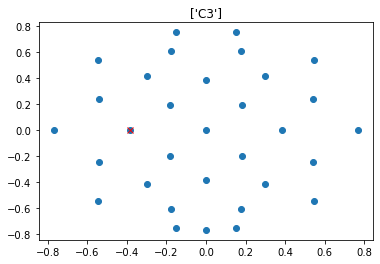

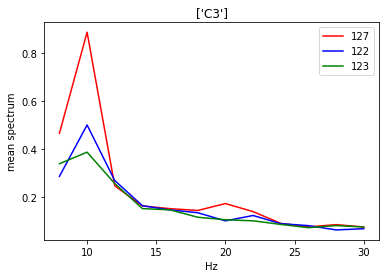

In [20]:
electrodes_name = ["C3"]
draw_electrodes_position_plot(rsession, electrodes_name)
output_task, output_data = eeg_processing(rsession, electrodes_name)

#create_mat_output(output_task, output_data, '0091', 1)

draw_plot(output_task, output_data, electrodes_name)


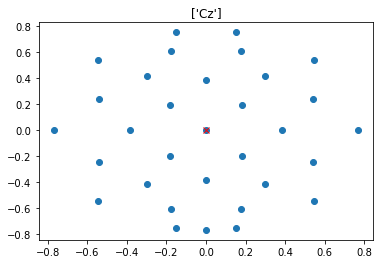

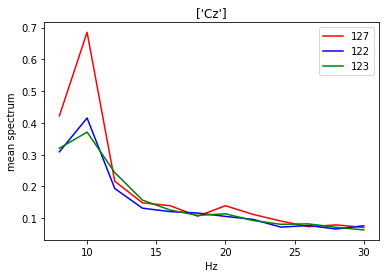

In [21]:
electrodes_name = ["Cz"]
draw_electrodes_position_plot(rsession, electrodes_name)
output_task, output_data = eeg_processing(rsession, electrodes_name)
draw_plot(output_task, output_data, electrodes_name)

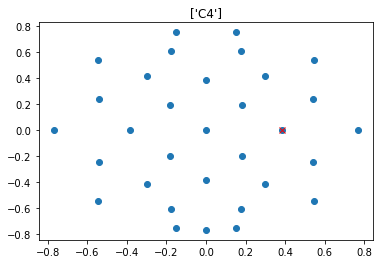

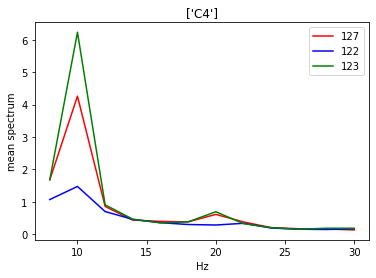

In [22]:
electrodes_name = ["C4"]
draw_electrodes_position_plot(rsession, electrodes_name)
output_task, output_data = eeg_processing(rsession, electrodes_name)
draw_plot(output_task, output_data, electrodes_name)

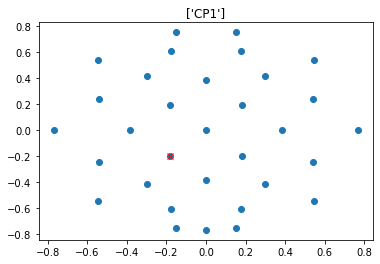

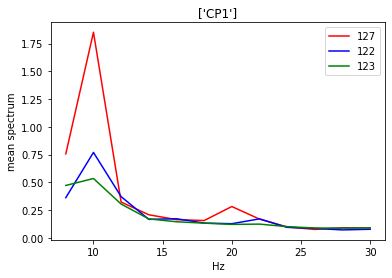

In [23]:
electrodes_name = ["CP1"]
draw_electrodes_position_plot(rsession, electrodes_name)
output_task, output_data = eeg_processing(rsession, electrodes_name)
draw_plot(output_task, output_data, electrodes_name)

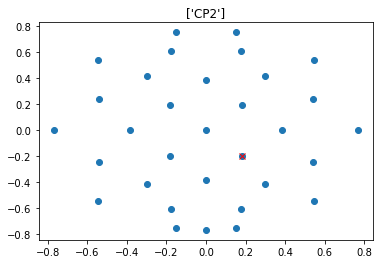

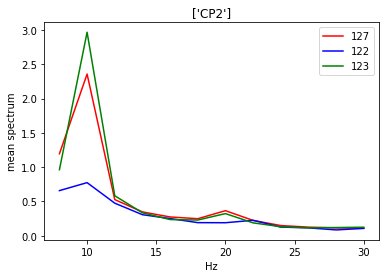

In [24]:
electrodes_name = ["CP2"]
draw_electrodes_position_plot(rsession, electrodes_name)
output_task, output_data = eeg_processing(rsession, electrodes_name)
draw_plot(output_task, output_data, electrodes_name)

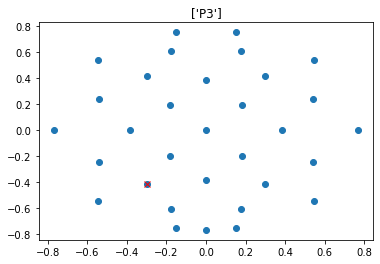

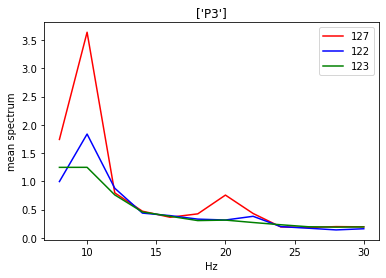

In [25]:
electrodes_name = ["P3"]
draw_electrodes_position_plot(rsession, electrodes_name)
output_task, output_data = eeg_processing(rsession, electrodes_name)
draw_plot(output_task, output_data, electrodes_name)

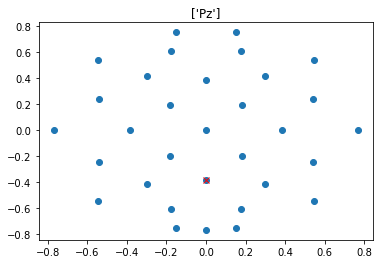

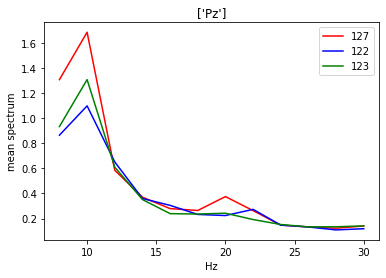

In [26]:
electrodes_name = ["Pz"]
draw_electrodes_position_plot(rsession, electrodes_name)
output_task, output_data = eeg_processing(rsession, electrodes_name)
draw_plot(output_task, output_data, electrodes_name)

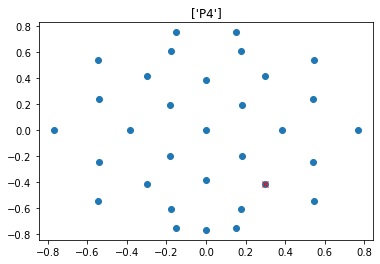

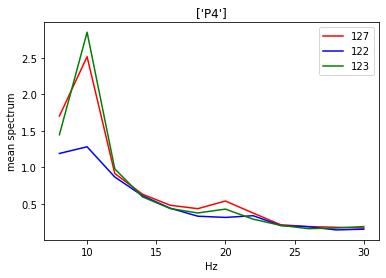

In [27]:
electrodes_name = ["P4"]
draw_electrodes_position_plot(rsession, electrodes_name)
output_task, output_data = eeg_processing(rsession, electrodes_name)
draw_plot(output_task, output_data, electrodes_name)

Observamos que los mejores electrodos para diferenciar 122 y 123 son P4, CP2, C4

In [28]:
electrodes_name = ["C4","CP2","P4"]
#draw_electrodes_position_plot(rsession, electrodes_name)
output_task, output_data = eeg_processing(rsession, electrodes_name)
#draw_plot(output_task, output_data, electrodes_name)

---------------------------------------

# YA REALIZADO EL CÓDIGO DE PROCESAMIENTO PASAMOS A CLASIFICAR:

# Procesamos 3 usuarios x 4 registros
Vamos a procesar 3 usuarios con 4 registros cada uno creando cada registro procesado en un nuevo fichero:

In [29]:
import scipy.io as sio
import pandas as pd
import numpy as np

users = ["0091", "0092", "0093"]

electrodes_name = ["C3", "Cz", "C4", "CP1", "CP2", "P3", "Pz", "P4"]
number_records = 4
for u in users: 
    for i in range(1,number_records+1):
        rsession = read_record('./RegistrosSinProcesar/user#'+ str(u) +'#20040101#0'+str(i)+'#reg001.mat')
        #draw_electrodes_position_plot(rsession, electrodes_name)
        output_task, output_data = eeg_processing(rsession, electrodes_name)
        #draw_plot(output_task, output_data, electrodes_name)
        create_mat_output(output_task, output_data, str(u), str(i))
        print("done record "+ str(i) +' user '+ str(u))


done record 1 user 0091
done record 2 user 0091
done record 3 user 0091
done record 4 user 0091
done record 1 user 0092
done record 2 user 0092
done record 3 user 0092
done record 4 user 0092
done record 1 user 0093
done record 2 user 0093
done record 3 user 0093
done record 4 user 0093


Código que usaremos para leer los registros creados: 

In [30]:
class ROutput:
    def __init__(self, task, data):
        self.task = task
        self.data = data
        
class OutTaskData: 
    def __init__(self, task, data): 
        self.task = task
        self.data = data

In [31]:
import scipy.io as sio
# Primero leemos los registros
def read_outputs(rec):
    '''read_outputs("userS0091f1.mat")'''
    mat = sio.loadmat(rec)
    #mdata = mat['output']
    #val = mdata[0,0]
    #output = ROutput(np.array(val["task"]), np.array(val["data"]))
    output = ROutput(np.array(mat["task"]), np.array(mat["data"]))
    return output

In [32]:
#output = read_outputs("userS0091f1.mat")
#output.task

### Clasificador BINARIO KNN con K-fold cross-validation (Práctica)
Usaremos KNN con K-fold cross-validation. 
El clasificador KNN (K-Nearest Neighbors), es un algoritmo de aprendizaje basado en instancias (Instace-based learning) que coge sus k valores más cercanos y predice haciendo la media de estos k valores. 

In [33]:
import numpy.matlib as npmt
from scipy import stats

def classifier_knn(X_test, X_train, y_train, k):
    #print((X_train))
    prediction = np.zeros((np.shape(X_test)[0],1))
    
    X_test = np.array(X_test)
    for i in range(0,np.shape(X_test)[0]):
        temp = X_test[i,:]
        temp2 = npmt.repmat(temp, np.shape(X_train)[0],1)
        temp3 = list(map(lambda x:x**2, temp2-X_train))
        temp4 = np.sqrt(np.sum(temp3, axis=1))[:,np.newaxis]
        temp5 = np.stack((temp4[:,0], np.array(y_train)[:,0]), axis = -1)
        
        temp6 = temp5[temp5[:,0].argsort()]
        prediction[i,0] = stats.mode(temp6[0:k,1])[0]
    return prediction

In [36]:
def kFoldCrossValidationKNN(user, task1, task2, k, total_records):
    """kFoldCrossValidationKNN('0091',122,123,5,4)"""
    lTaskData = []
    for i_rec in range(1,total_records+1):
        record = "userS"+user+"f"+str(i_rec)+".mat"
        output = read_outputs(record) # output.task será y, output.data será x
        
        outT = (output.task == task1) | (output.task == task2)
        outData = output.data[outT[:,0],0:np.shape(output.data)[1]]
        outTask = output.task[outT[:,0]]
        outTD = OutTaskData(outTask, outData)
        lTaskData.append(outTD)

    # K-FOLD CROSS-VALIDATION
    success = np.zeros((1,total_records))[0]
    
    for i in range(0,total_records):
        X_train, y_train, X_test, y_test = [],[],[],[] 
        for j in range(0,total_records):
            if i==j: 
                X_test.extend(lTaskData[j].data)
                y_test.extend(lTaskData[j].task)
            else: 
                X_train.extend(lTaskData[j].data)
                y_train.extend(lTaskData[j].task)
        #print(np.shape(X_train), np.shape(y_train),np.shape(X_test), np.shape(y_test))
        # KNN
        KNN_classifier = classifier_knn(X_test, X_train, y_train, k)
        
        success[i] = np.mean(KNN_classifier == y_test)*100
    
    return round(np.mean(success),2), round(np.std(success),2)
    """
    print("K = ", k)
    print('User ', user, '- knn: ',k, "- tasks: ",task1, task2)
    print(success)
    print('Mean success: ', np.mean(success)," std: ",np.std(success))
    print()
    """

In [ ]:
results_KNN_df = pd.DataFrame()

K_range_KNN = [1, 3, 5, 15] 
tasks = {122:123, 127:122, 123:127}

for k in range(len(K_range_KNN)):
    accuracy_l = []
    std_l = []
    for i in tasks:        
        accuracy, std = kFoldCrossValidationKNN('0091', i, tasks[i], K_range_KNN[k],4) ## LLAMADA AL CLASIFICADOR
        accuracy_l.append(accuracy)
        std_l.append(std)
        
    results_KNN_df = results_KNN_df.append({'KNN:':"k =" + str(K_range_KNN[k]), '22-23': str(accuracy_l[0]) + " +- "+str(std_l[0]),
                                    '22-27': str(accuracy_l[1]) + " +- "+str(std_l[1]),
                                    '23-27': str(accuracy_l[2]) + " +- "+str(std_l[2])}, ignore_index=True)

    
results_KNN_df

### Otros Modelos: 

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import LinearSVC, SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [32]:
def read_records(user, total_records, task1, task2, task3 = ""):
    """ Used in train_model"""
    lTaskData = []
    for i_rec in range(1,total_records+1):
        record = "userS"+user+"f"+str(i_rec)+".mat"
        output = read_outputs(record) # output.task será y, output.data será x
        if task3 != "":
            outT = (output.task == task1) | (output.task == task2) | (output.task == task3) 
        else: 
            outT = (output.task == task1) | (output.task == task2) 
        outData = output.data[outT[:,0],0:np.shape(output.data)[1]]
        outTask = output.task[outT[:,0]]
        outTD = OutTaskData(outTask, outData)
        lTaskData.append(outTD)
        
    return lTaskData

In [33]:
def return_X_y_train_and_test(total_records, i, lTaskData):
    """ Used in train_model"""
    X_train, y_train, X_test, y_test = [],[],[],[] 
    for j in range(0,total_records):
        if i==j: 
            X_test.extend(lTaskData[j].data)
            y_test.extend(lTaskData[j].task)
        else: 
            X_train.extend(lTaskData[j].data)
            y_train.extend(lTaskData[j].task)
    X_train = np.array(X_train)
    #X_train_df = pd.DataFrame(data = X_train)
    #print(X_train_df.describe())
    #plt.figure(figsize = (10,10))
    #X_train_df.iloc[0:5].T.hist(sharey=True, layout=(1, 5), figsize=(12, 3));
    #plt.show()
    y_train = np.ravel(np.array(y_train))
    X_test = np.array(X_test)
    y_test = np.ravel(np.array(y_test))
    
    return X_train, y_train, X_test, y_test

In [34]:
from sklearn.metrics import f1_score
import joblib

def obtain_model(model_clf, model_name, user, total_records, task1, task2, task3 = ""):
    """obtain_model(model, model_name, '0091',5,4,122,123)"""
    """obtain_model(model, model_name, '0091',5,4,122,123, 127)"""
    lTaskData = read_records(user, total_records, task1, task2, task3)
        
    # K-FOLD CROSS-VALIDATION
    success = np.zeros((1,total_records))[0]
    accuracies = np.zeros((1, total_records))[0]
    f1_scores = np.zeros((1, total_records))[0]
    best_f1_score = 0
    
    for i in range(0,total_records):
        X_train, y_train, X_test, y_test = return_X_y_train_and_test(total_records, i, lTaskData)
        
        # Train model
        model_clf.fit(X_train, y_train)
        y_pred = model_clf.predict(X_test)
        success[i] = np.mean(y_pred == y_test)*100 # A mano
        accuracies[i] = model_clf.score(X_test, y_test) # Método sklearn -> return the mean accuracy
        # Como a veces la métrica accuracy (que es la que hemos usado en success y accuracies) es engañosa cuando las clases
        # están desbalanceadas, vamos a usar la métrica F1. 
        # La métrica F1 es una métrica que combina precision (nos da la calidad de la predicción, que % de lo 
        # que hemos predicho que es positivo en realidad lo es) y recall (nos da la cantidad, que % de la clase positiva
        # hemos sido capaces de identificar), para ello realiza la media armónica (harmonic mean) que da mucho más peso a 
        # valores bajos 
        f1_scores[i] = f1_score(y_test, y_pred, average="macro")
        # Guardo el mejor modelo
        if f1_scores[i]> best_f1_score:
            joblib.dump(model_clf, './Modelos/'+model_name+'_clf_'+str(user)+'_'+str(task1)+'_'+str(task2)+'_'+str(task3)+'.pkl') 
            # Para cargar el modelo: knn_clf = joblib.load('knn_clf.pkl') # Carga del modelo.
            best_f1_score = f1_scores[i]
    
    return round(np.mean(success),2), round(np.std(success),2), round(np.mean(f1_scores)*100, 2)

In [45]:
def show_results(tasks, model_clf, model_name,  user, total_records):
    results_df = pd.DataFrame()
    
    accuracy_l = []
    std_l = []
    f1_score_mean_l = []
    for i in tasks:        
        accuracy, std, f1_score_mean = obtain_model(model_clf, model_name, user, total_records, i, tasks[i]) ## LLAMADA AL CLASIFICADOR
        accuracy_l.append(accuracy)
        std_l.append(std)
        f1_score_mean_l.append(f1_score_mean)
    
    accuracy_all, std_all, f1_score_mean_all = obtain_model(model_clf, model_name, user,total_records, 122, 123, 127) ## LLAMADA AL CLASIFICADOR
    accuracy_l.append(accuracy_all)
    std_l.append(std_all)
    f1_score_mean_l.append(f1_score_mean_all)
        
    results_df = results_df.append({'Model':model_name, 'USER': str(user), '22-23': "Acc: "+ str(accuracy_l[0]) + " +- "+str(std_l[0]) +" || F1: "+str(f1_score_mean_l[0]),
                                    '22-27': "Acc: "+str(accuracy_l[1]) + " +- "+str(std_l[1])+" || F1: "+str(f1_score_mean_l[1]),
                                    '23-27': "Acc: "+str(accuracy_l[2]) + " +- "+str(std_l[2])+" || F1: "+str(f1_score_mean_l[2]),
                                    '22-23-27': "Acc: "+str(accuracy_l[3]) + " +- "+str(std_l[3])+" || F1: "+str(f1_score_mean_l[3])}, ignore_index=True)


    return results_df

In [46]:
def show_results_only_LinearSVM(tasks,  user, total_records):
    users = ["0091", "0092", "0093"]
    if user == users[0]:
        maxiters = {122:50000, 127: 70000, 123: 200000, "all": 300000}
    elif user == users[1]:
        maxiters = {122:200000, 127: 400000, 123: 300000, "all": 500000}
    elif user == users[2]:
        maxiters = {122:200000, 127: 300000, 123: 200000, "all": 300000}
    results_df = pd.DataFrame()
    
    accuracy_l = []
    std_l = []
    f1_score_mean_l = []
    for i in tasks:        
        
        # Build model 
        # 3 - SVM
        # LinearSVM 
        maxiter = maxiters[i]
        svm_linear_clf = make_pipeline(MinMaxScaler(), LinearSVC(C = 1, loss = "hinge", dual = True,  max_iter = maxiter, random_state = 42))   
        model_name = "svm_linear"
        
        accuracy, std, f1_score_mean = obtain_model(svm_linear_clf, model_name, user, total_records, i, tasks[i]) ## LLAMADA AL CLASIFICADOR
        accuracy_l.append(accuracy)
        std_l.append(std)
        f1_score_mean_l.append(f1_score_mean)
    
    # Build model 
    # 3 - SVM
    # LinearSVM 
    
    maxiter = maxiters["all"]
    svm_linear_clf = make_pipeline(MinMaxScaler(), LinearSVC(C = 1, loss = "hinge", dual = True,  max_iter = maxiter, random_state = 42))   
    model_name = "svm_linear"
    
    accuracy_all, std_all, f1_score_mean_all = obtain_model(svm_linear_clf, model_name, user,total_records, 122, 123, 127) ## LLAMADA AL CLASIFICADOR
    accuracy_l.append(accuracy_all)
    std_l.append(std_all)
    f1_score_mean_l.append(f1_score_mean_all)
        
    results_df = results_df.append({'Model':model_name, 'USER': str(user), '22-23': "Acc: "+ str(accuracy_l[0]) + " +- "+str(std_l[0]) +" || F1: "+str(f1_score_mean_l[0]),
                                    '22-27': "Acc: "+str(accuracy_l[1]) + " +- "+str(std_l[1])+" || F1: "+str(f1_score_mean_l[1]),
                                    '23-27': "Acc: "+str(accuracy_l[2]) + " +- "+str(std_l[2])+" || F1: "+str(f1_score_mean_l[2]),
                                    '22-23-27': "Acc: "+str(accuracy_l[3]) + " +- "+str(std_l[3])+" || F1: "+str(f1_score_mean_l[3])}, ignore_index=True)


    return results_df

Variables: 

In [37]:
tasks = {122:123, 123:127, 127:122}
users = ["0091", "0092", "0093"]
total_records = 4

Find best parameters with GridSearch for some models: 

In [38]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [39]:
def run_grid_search(param_grid, model_grid):
    
    tasks = {122:123, 123:127, 127:122}
    users = ["0091", "0092", "0093"]
    total_records = 4
    
    for u in users:
        for t in tasks: 
            for i in range(0,total_records):
                lTaskData = read_records(u, total_records, t, tasks[t])
                X_train, y_train, X_test, y_test = return_X_y_train_and_test(total_records, i, lTaskData)
                grid_search = GridSearchCV (model_grid, param_grid, cv = total_records, scoring = 'accuracy', return_train_score = True)
                grid_search.fit(X_train, y_train)
                print(str(u), str(t), str(i), grid_search.best_estimator_, round(grid_search.best_score_,2))

In [44]:
# KNN
run_grid_search([{'n_neighbors':[1, 3, 5, 15]}], KNeighborsClassifier())

0091 122 0 KNeighborsClassifier(n_neighbors=15) 0.8
0091 122 1 KNeighborsClassifier(n_neighbors=15) 0.75
0091 122 2 KNeighborsClassifier(n_neighbors=15) 0.78
0091 122 3 KNeighborsClassifier(n_neighbors=15) 0.78
0091 123 0 KNeighborsClassifier(n_neighbors=15) 0.82
0091 123 1 KNeighborsClassifier(n_neighbors=15) 0.78
0091 123 2 KNeighborsClassifier(n_neighbors=15) 0.75
0091 123 3 KNeighborsClassifier(n_neighbors=15) 0.77
0091 127 0 KNeighborsClassifier(n_neighbors=15) 0.78
0091 127 1 KNeighborsClassifier(n_neighbors=15) 0.75
0091 127 2 KNeighborsClassifier(n_neighbors=3) 0.74
0091 127 3 KNeighborsClassifier(n_neighbors=15) 0.72
0092 122 0 KNeighborsClassifier(n_neighbors=15) 0.58
0092 122 1 KNeighborsClassifier(n_neighbors=15) 0.55
0092 122 2 KNeighborsClassifier(n_neighbors=15) 0.53
0092 122 3 KNeighborsClassifier(n_neighbors=15) 0.55
0092 123 0 KNeighborsClassifier(n_neighbors=15) 0.68
0092 123 1 KNeighborsClassifier(n_neighbors=15) 0.68
0092 123 2 KNeighborsClassifier(n_neighbors=15) 

In [45]:
# TREE
run_grid_search([{'max_depth':[3, 5, 10, 15]}], tree.DecisionTreeClassifier())

0091 122 0 DecisionTreeClassifier(max_depth=5) 0.75
0091 122 1 DecisionTreeClassifier(max_depth=5) 0.74
0091 122 2 DecisionTreeClassifier(max_depth=5) 0.72
0091 122 3 DecisionTreeClassifier(max_depth=3) 0.76
0091 123 0 DecisionTreeClassifier(max_depth=5) 0.81
0091 123 1 DecisionTreeClassifier(max_depth=3) 0.77
0091 123 2 DecisionTreeClassifier(max_depth=3) 0.76
0091 123 3 DecisionTreeClassifier(max_depth=3) 0.8
0091 127 0 DecisionTreeClassifier(max_depth=3) 0.76
0091 127 1 DecisionTreeClassifier(max_depth=3) 0.74
0091 127 2 DecisionTreeClassifier(max_depth=3) 0.74
0091 127 3 DecisionTreeClassifier(max_depth=5) 0.71
0092 122 0 DecisionTreeClassifier(max_depth=3) 0.56
0092 122 1 DecisionTreeClassifier(max_depth=3) 0.58
0092 122 2 DecisionTreeClassifier(max_depth=3) 0.54
0092 122 3 DecisionTreeClassifier(max_depth=10) 0.53
0092 123 0 DecisionTreeClassifier(max_depth=3) 0.65
0092 123 1 DecisionTreeClassifier(max_depth=3) 0.68
0092 123 2 DecisionTreeClassifier(max_depth=5) 0.67
0092 123 3 D

In [46]:
run_grid_search([{'n_estimators':[ 10, 100, 500], 'max_depth': [5, 10, 100], 'random_state': [42]}], RandomForestClassifier())

0091 122 0 RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42) 0.82
0091 122 1 RandomForestClassifier(max_depth=100, n_estimators=500, random_state=42) 0.76
0091 122 2 RandomForestClassifier(max_depth=100, n_estimators=500, random_state=42) 0.78
0091 122 3 RandomForestClassifier(max_depth=5, n_estimators=500, random_state=42) 0.79
0091 123 0 RandomForestClassifier(max_depth=100, n_estimators=500, random_state=42) 0.85
0091 123 1 RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42) 0.81
0091 123 2 RandomForestClassifier(max_depth=100, n_estimators=500, random_state=42) 0.79
0091 123 3 RandomForestClassifier(max_depth=10, n_estimators=500, random_state=42) 0.81
0091 127 0 RandomForestClassifier(max_depth=100, n_estimators=500, random_state=42) 0.81
0091 127 1 RandomForestClassifier(max_depth=100, n_estimators=500, random_state=42) 0.78
0091 127 2 RandomForestClassifier(max_depth=100, random_state=42) 0.77
0091 127 3 RandomForestClassifier(max_depth=

In [47]:
run_grid_search([{'n_estimators':[ 10, 100, 500], 'max_depth': [5, 10, 100], 'random_state': [42]}], ExtraTreesClassifier())

0091 122 0 ExtraTreesClassifier(max_depth=100, n_estimators=500, random_state=42) 0.82
0091 122 1 ExtraTreesClassifier(max_depth=100, n_estimators=500, random_state=42) 0.77
0091 122 2 ExtraTreesClassifier(max_depth=100, random_state=42) 0.79
0091 122 3 ExtraTreesClassifier(max_depth=100, n_estimators=500, random_state=42) 0.79
0091 123 0 ExtraTreesClassifier(max_depth=100, n_estimators=500, random_state=42) 0.85
0091 123 1 ExtraTreesClassifier(max_depth=5, n_estimators=10, random_state=42) 0.81
0091 123 2 ExtraTreesClassifier(max_depth=10, n_estimators=500, random_state=42) 0.78
0091 123 3 ExtraTreesClassifier(max_depth=10, n_estimators=500, random_state=42) 0.8
0091 127 0 ExtraTreesClassifier(max_depth=100, n_estimators=500, random_state=42) 0.8
0091 127 1 ExtraTreesClassifier(max_depth=100, n_estimators=500, random_state=42) 0.77
0091 127 2 ExtraTreesClassifier(max_depth=100, random_state=42) 0.78
0091 127 3 ExtraTreesClassifier(max_depth=100, n_estimators=500, random_state=42) 0.75

Build models: 

In [49]:
knn_results_all_k_df = pd.DataFrame()

K_range_KNN = [1, 3, 5, 15]
for u in users: 
    for k in range(len(K_range_KNN)):
        knn_clf = KNeighborsClassifier(n_neighbors = K_range_KNN[k])
        knn_results_all_k_df = pd.concat([knn_results_all_k_df, show_results(tasks,  knn_clf, str(u)+"_kFoldCrossValidationKNNsk_"+str( K_range_KNN[k]),  u, total_records)])
knn_results_all_k_df

,22-23,22-23-27,22-27,23-27,Model,USER
0,Acc: 73.11 +- 4.26 || F1: 72.7,Acc: 57.29 +- 5.4 || F1: 56.64,Acc: 71.59 +- 4.05 || F1: 71.35,Acc: 69.83 +- 6.68 || F1: 69.23,0091_kFoldCrossValidationKNNsk_1,0091
0,Acc: 76.47 +- 4.28 || F1: 76.13,Acc: 60.75 +- 6.53 || F1: 60.05,Acc: 75.12 +- 6.25 || F1: 74.88,Acc: 72.99 +- 4.77 || F1: 72.51,0091_kFoldCrossValidationKNNsk_3,0091
0,Acc: 77.74 +- 3.49 || F1: 77.38,Acc: 62.72 +- 6.04 || F1: 61.94,Acc: 75.98 +- 5.73 || F1: 75.7,Acc: 73.54 +- 4.69 || F1: 73.1,0091_kFoldCrossValidationKNNsk_5,0091
0,Acc: 78.45 +- 3.56 || F1: 78.09,Acc: 65.09 +- 7.0 || F1: 64.27,Acc: 77.95 +- 5.98 || F1: 77.65,Acc: 75.67 +- 6.45 || F1: 75.32,0091_kFoldCrossValidationKNNsk_15,0091
0,Acc: 52.22 +- 4.75 || F1: 51.08,Acc: 43.89 +- 4.29 || F1: 42.5,Acc: 62.2 +- 4.2 || F1: 61.83,Acc: 67.19 +- 2.74 || F1: 65.72,0092_kFoldCrossValidationKNNsk_1,0092
0,Acc: 54.0 +- 3.8 || F1: 52.46,Acc: 45.01 +- 4.48 || F1: 44.27,Acc: 62.01 +- 3.6 || F1: 61.59,Acc: 69.61 +- 2.16 || F1: 68.24,0092_kFoldCrossValidationKNNsk_3,0092
0,Acc: 53.91 +- 3.94 || F1: 52.15,Acc: 44.77 +- 4.55 || F1: 43.85,Acc: 63.63 +- 3.82 || F1: 63.03,Acc: 70.8 +- 3.05 || F1: 69.47,0092_kFoldCrossValidationKNNsk_5,0092
0,Acc: 52.64 +- 3.97 || F1: 49.84,Acc: 47.84 +- 4.31 || F1: 45.82,Acc: 67.09 +- 2.96 || F1: 66.55,Acc: 73.26 +- 3.82 || F1: 71.67,0092_kFoldCrossValidationKNNsk_15,0092
0,Acc: 53.76 +- 1.89 || F1: 53.64,Acc: 43.56 +- 1.55 || F1: 43.54,Acc: 64.81 +- 1.82 || F1: 64.7,Acc: 61.55 +- 2.26 || F1: 61.34,0093_kFoldCrossValidationKNNsk_1,0093
0,Acc: 53.76 +- 1.71 || F1: 53.62,Acc: 44.85 +- 2.35 || F1: 44.86,Acc: 66.58 +- 1.7 || F1: 66.32,Acc: 64.28 +- 2.93 || F1: 63.93,0093_kFoldCrossValidationKNNsk_3,0093


In [48]:
all_results_df = pd.DataFrame()


for u in users: 
    print("Doing user ", str(u))
    
    # 1 - KNN 
    print("KNN")
    knn_clf = KNeighborsClassifier(n_neighbors = 15)
    all_results_df = pd.concat([all_results_df, show_results(tasks,  knn_clf, "knn_"+str(15), u, total_records)])
    
    # 2 - SGD
    # SGDClassifier : Linear SVM
    print("SGDClassifier : Linear SVM")
    sgd_linear_clf = make_pipeline(MinMaxScaler(), SGDClassifier(random_state=42)) # SGDClassifier loss default "hinge" which gives a linear SVM
    all_results_df = pd.concat([all_results_df, show_results(tasks,  sgd_linear_clf, "sgd_linear",  u, total_records)])
    # SGDClassifier : Logistic Regression
    print("SGDClassifier : Logistic Regression")
    sgd_logistic_clf = make_pipeline(MinMaxScaler(), SGDClassifier(loss = "log", random_state=42)) # SGDClassifier loss default "hinge" which gives a linear SVM
    all_results_df = pd.concat([all_results_df, show_results(tasks,  sgd_logistic_clf, "sgd_logistic",  u, total_records)])
    
    # 3 - SVM
    # LinearSVM 
    print("LinearSVM ")
    all_results_df = pd.concat([all_results_df, show_results_only_LinearSVM(tasks, u, total_records)])    
    # Gaussian RBF Kernel
    print("SVM - Gaussian RBF Kernel ")
    svm_rbf_clf = make_pipeline(MinMaxScaler(), SVC(kernel = "rbf", gamma = 0.1, C = 10, random_state = 42)) 
    all_results_df = pd.concat([all_results_df, show_results(tasks,  svm_rbf_clf, "svm_rbf",  u, total_records)])    
    
    # 4 - Tree
    # DecisionTreeClassifier
    print("Tree")
    tree_clf = tree.DecisionTreeClassifier(max_depth = 3, random_state = 42)
    all_results_df = pd.concat([all_results_df, show_results(tasks,  tree_clf, "tree",  u, total_records)]) 
    
    # 5 - Random Trees
    # RandomForestClassifier
    print("RandomForestClassifier")
    rfc_clf = RandomForestClassifier(n_estimators = 100, max_depth = 500, random_state = 42) # 500 y 10
    all_results_df = pd.concat([all_results_df, show_results(tasks,  rfc_clf, "rfc",  u, total_records)])  
    # ExtraTreesClassifier
    print("ExtraTreesClassifier")
    extra_trees_clf = ExtraTreesClassifier(n_estimators = 500, max_depth = 100, random_state = 42) # 500 y 100
    all_results_df = pd.concat([all_results_df, show_results(tasks,  extra_trees_clf, "extra_trees",  u, total_records)]) 
    
    # 6 - Naive Bayes
    # GaussianNB
    print("GaussianNB")
    gnb_clf = GaussianNB()
    all_results_df = pd.concat([all_results_df, show_results(tasks,  gnb_clf, "gnb",  u, total_records)])  
    # MultinomialNB
    print("MultinomialNB")
    mnb_clf = MultinomialNB()
    all_results_df = pd.concat([all_results_df, show_results(tasks,  mnb_clf, "mnb",  u, total_records)]) 
    # BernoulliNB
    print("BernoulliNB")
    bnb_clf = BernoulliNB()
    all_results_df = pd.concat([all_results_df, show_results(tasks,  bnb_clf, "bnb",  u, total_records)]) 
    
    # 7 - Softmax
    # LogisticRegression
    print("Softmax")
    softmax_clf = make_pipeline(MinMaxScaler(), LogisticRegression(multi_class = "multinomial", solver = "lbfgs", C = 10, max_iter = 300, random_state = 42))
    all_results_df = pd.concat([all_results_df, show_results(tasks,  softmax_clf, "softmax",  u, total_records)]) 
            # Ha ocurrido que no converge lbfgs failed to converge (status=1):
            # Aquí explican el porqué https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter
            # Vamos a probar aumentando las iters
    # 8 - Discriminant Analysis
    # LinearDiscriminantAnalysis
    print("LinearDiscriminantAnalysis")
    linearda_clf = make_pipeline(MinMaxScaler(), LinearDiscriminantAnalysis()) 
    all_results_df = pd.concat([all_results_df, show_results(tasks,  linearda_clf, "linearda",  u, total_records)]) 
    # QuadraticDiscriminantAnalysis
    print("QuadraticDiscriminantAnalysis")
    quadraticda_clf = make_pipeline(MinMaxScaler(), QuadraticDiscriminantAnalysis())
    all_results_df = pd.concat([all_results_df, show_results(tasks,  quadraticda_clf, "quadraticda",  u, total_records)]) 
    
    print("Done user ", str(u))
    print()
all_results_df

Doing user  0091
KNN
SGDClassifier : Linear SVM
SGDClassifier : Logistic Regression
LinearSVM 
SVM - Gaussian RBF Kernel 
Tree
RandomForestClassifier
ExtraTreesClassifier
GaussianNB
MultinomialNB
BernoulliNB
Softmax
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
Done user  0091

Doing user  0092
KNN
SGDClassifier : Linear SVM
SGDClassifier : Logistic Regression
LinearSVM 
SVM - Gaussian RBF Kernel 
Tree
RandomForestClassifier
ExtraTreesClassifier
GaussianNB
MultinomialNB
BernoulliNB
Softmax
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
Done user  0092

Doing user  0093
KNN
SGDClassifier : Linear SVM
SGDClassifier : Logistic Regression
LinearSVM 
SVM - Gaussian RBF Kernel 
Tree
RandomForestClassifier
ExtraTreesClassifier
GaussianNB
MultinomialNB
BernoulliNB
Softmax
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
Done user  0093



,22-23,22-23-27,22-27,23-27,Model,USER
0,Acc: 78.45 +- 3.56 || F1: 78.09,Acc: 65.09 +- 7.0 || F1: 64.27,Acc: 77.95 +- 5.98 || F1: 77.65,Acc: 75.67 +- 6.45 || F1: 75.32,knn_15,0091
0,Acc: 78.88 +- 5.19 || F1: 78.24,Acc: 68.07 +- 3.78 || F1: 66.73,Acc: 81.68 +- 5.32 || F1: 81.44,Acc: 76.17 +- 1.85 || F1: 75.45,sgd_linear,0091
0,Acc: 78.54 +- 3.56 || F1: 78.33,Acc: 68.34 +- 5.45 || F1: 67.43,Acc: 80.05 +- 5.5 || F1: 79.47,Acc: 77.51 +- 3.45 || F1: 76.91,sgd_logistic,0091
0,Acc: 80.15 +- 5.13 || F1: 79.62,Acc: 68.56 +- 6.49 || F1: 67.54,Acc: 81.94 +- 5.87 || F1: 81.65,Acc: 76.45 +- 4.86 || F1: 75.9,svm_linear,0091
0,Acc: 79.34 +- 4.89 || F1: 78.83,Acc: 67.57 +- 6.78 || F1: 66.83,Acc: 80.03 +- 4.97 || F1: 79.79,Acc: 76.77 +- 4.32 || F1: 76.18,svm_rbf,0091
0,Acc: 75.18 +- 5.08 || F1: 74.76,Acc: 65.25 +- 6.3 || F1: 64.78,Acc: 78.88 +- 6.55 || F1: 78.61,Acc: 73.24 +- 2.47 || F1: 72.5,tree,0091
0,Acc: 79.16 +- 3.65 || F1: 78.72,Acc: 68.34 +- 6.86 || F1: 67.34,Acc: 81.3 +- 7.12 || F1: 81.06,Acc: 77.62 +- 4.08 || F1: 76.76,rfc,0091
0,Acc: 80.32 +- 3.96 || F1: 79.84,Acc: 68.1 +- 6.44 || F1: 67.03,Acc: 81.87 +- 6.8 || F1: 81.65,Acc: 77.22 +- 4.18 || F1: 76.37,extra_trees,0091
0,Acc: 55.18 +- 11.24 || F1: 48.41,Acc: 51.15 +- 11.73 || F1: 44.97,Acc: 62.45 +- 13.51 || F1: 50.35,Acc: 70.5 +- 8.95 || F1: 69.92,gnb,0091
0,Acc: 74.01 +- 2.99 || F1: 73.5,Acc: 61.2 +- 6.98 || F1: 60.12,Acc: 78.88 +- 6.41 || F1: 78.62,Acc: 70.19 +- 11.17 || F1: 69.23,mnb,0091


In [50]:
all_results_df

,22-23,22-23-27,22-27,23-27,Model,USER
0,Acc: 78.45 +- 3.56 || F1: 78.09,Acc: 65.09 +- 7.0 || F1: 64.27,Acc: 77.95 +- 5.98 || F1: 77.65,Acc: 75.67 +- 6.45 || F1: 75.32,knn_15,0091
0,Acc: 78.88 +- 5.19 || F1: 78.24,Acc: 68.07 +- 3.78 || F1: 66.73,Acc: 81.68 +- 5.32 || F1: 81.44,Acc: 76.17 +- 1.85 || F1: 75.45,sgd_linear,0091
0,Acc: 78.54 +- 3.56 || F1: 78.33,Acc: 68.34 +- 5.45 || F1: 67.43,Acc: 80.05 +- 5.5 || F1: 79.47,Acc: 77.51 +- 3.45 || F1: 76.91,sgd_logistic,0091
0,Acc: 80.15 +- 5.13 || F1: 79.62,Acc: 68.56 +- 6.49 || F1: 67.54,Acc: 81.94 +- 5.87 || F1: 81.65,Acc: 76.45 +- 4.86 || F1: 75.9,svm_linear,0091
0,Acc: 79.34 +- 4.89 || F1: 78.83,Acc: 67.57 +- 6.78 || F1: 66.83,Acc: 80.03 +- 4.97 || F1: 79.79,Acc: 76.77 +- 4.32 || F1: 76.18,svm_rbf,0091
0,Acc: 75.18 +- 5.08 || F1: 74.76,Acc: 65.25 +- 6.3 || F1: 64.78,Acc: 78.88 +- 6.55 || F1: 78.61,Acc: 73.24 +- 2.47 || F1: 72.5,tree,0091
0,Acc: 79.16 +- 3.65 || F1: 78.72,Acc: 68.34 +- 6.86 || F1: 67.34,Acc: 81.3 +- 7.12 || F1: 81.06,Acc: 77.62 +- 4.08 || F1: 76.76,rfc,0091
0,Acc: 80.32 +- 3.96 || F1: 79.84,Acc: 68.1 +- 6.44 || F1: 67.03,Acc: 81.87 +- 6.8 || F1: 81.65,Acc: 77.22 +- 4.18 || F1: 76.37,extra_trees,0091
0,Acc: 55.18 +- 11.24 || F1: 48.41,Acc: 51.15 +- 11.73 || F1: 44.97,Acc: 62.45 +- 13.51 || F1: 50.35,Acc: 70.5 +- 8.95 || F1: 69.92,gnb,0091
0,Acc: 74.01 +- 2.99 || F1: 73.5,Acc: 61.2 +- 6.98 || F1: 60.12,Acc: 78.88 +- 6.41 || F1: 78.62,Acc: 70.19 +- 11.17 || F1: 69.23,mnb,0091


---------------------------------------------------------------

# To plot figures 

In [69]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Otros clasificadores
Implementaremos otros clasificadores de manera que sirvan para clasificar 2 o 3 clases

(Enlace interesante sobre Precision, Recall, F1, Accuracy en clasificación: https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/ )

(Importante memoria TFM: https://scikit-learn.org/stable/modules/multiclass.html ) 

### 1 - KNN - K fold cross validation - sklearn 

Vamos a usar el mismo código para validación cruzada ya que en el código de validación cruzada de sklearn haría los slipts del conjunto de datos de manera aleatoria, pero en este caso queremos usar los registros como cada uno de los k del k fold cross-validation.

(Explicación matemática y más...: https://scikit-learn.org/stable/modules/neighbors.html )

### 2 - SGD Classifier - K fold cross-validation - sklearn


Vamos a usar el SGD Classifier (Stochastic Gradient Descent), el cual trata con las instancias de entrenamiento de una en una, es decir, de manera independiente. Es un algoritmo de optimización que trata de encontrar soluciones óptimas ajustando los parámetros de forma iterativa para minimizar la función de coste (cost function) que penaliza para 2 (o más) clases. También hay que destacar que al tener naturaleza estocástica, una vez se acerque al minímo seguirá rebotando cerca de él, por tanto cuando el algoritmo se detiene los valores finales son buenos, pero no del todo óptimos. La aletoriedad será buena para escapar de óptimos locales. 

Por defecto la función de pérdida o coste que utilice es la función hinge, el cual proporciona una máquina de vector soporte lineal (SVM) (SGDClassifier(loss="hinge", alpha=1/
(m*C)). This applies regular Stochastic Gradient Descent (see Chapter 4) to train a
linear SVM classifier.). La función de coste hinge (bisagra) es max(0, 1-t), a veces se la llama softmax. Esta función hinge es una función "lazzy", es decir, solo actualiza los parámetros del modelo si un ejemplo viola la restricción de margen, haciendo que el entrenamiento sea muy eficiente. 

Para que la función de pérdida no sea una superficie alargada (elongate surface) hay que normalizar primero los datos para que converger al mínimo no se realice de una manera ineficiente, así las funciones de coste (pérdida) con respecto a los pesos estarán más equilibradas. Para normalizar podemos usar min-max o estandarización (recomendada si hay valores atípicos). 


(Explicación matemática y más...: https://scikit-learn.org/stable/modules/sgd.html#sgd )

### 3 - SVM - K fold cross-validation - sklearn

Las máquinas vector soporte son uno de los algoritmos de machine Learning más populares, pueden servir tanto para regresión, clasificación como para detectar outliers. Aquí nos vamos a centrar en clasificación. Las SVM encuentran la mejor separación posible entre clases. Con dos dimensiones es fácil entender lo que hace: crea una línea recta (en el caso del SVM lineal) que separa de la mejor manera las dos clases. Normalmente, los problemas de aprendizaje automático tienen muchísimas dimensiones. Así que en vez de encontrar la línea óptima, el SVM encuentra el hiperplano que maximiza el margen de separación entre clases.
Los vectores soporte son los "puntos" que definen el márgen máximo de separación del hiperplano que separa las clases. Son vectores en vez de puntos porque estos «puntos» tienen tantos elementos como dimensiones tenga nuestro espacio de entrada. Es decir, estos puntos multi-dimensionales se representan con con vector de n dimensiones.

Las clases se separan por dos espacios llamadas calles ("street") la recta (en el caso del lineal) que separa estas dos calles es la recta de clasificación, las dos lineas que separan las calles de las clases se crean por los vectores soporte). El objetivo que debemos alcanzar es mantener la "calle" lo más grande posible y limitar las "violaciones de margen" ("margins violations": instancias en el medio de la calle o en el lado equivocado), por ello realizaremos clasificaciones de margen blando ("Soft Margin Classification")

Primero, probaremos con el kernel lineal (LinearSVC es más rápido que SVC(kernel="linear")), si el conjunto de entrenamiento no es muy grande se recomienda probar el kernel en función de base radial gaussiana (SVC (kernel="rbf")).
Si vemos que el modelo tiene overfitting, podemos regularizarlo utilizando el parámetro C. Es destacable que tanto SVC como LinearSVC son multiclase. SVC implementan el método ovo ("uno contra uno", se construyen clasificadores y cada uno entrena datos de dos clases)  y LinearSVC ovr (“uno contra el resto”)

(Hiperplanos: https://www.cienciadedatos.net/documentos/34_maquinas_de_vector_soporte_support_vector_machines)

(Buena explicación: https://www.iartificial.net/maquinas-de-vectores-de-soporte-svm/)

(Explicación matemática y más...: https://scikit-learn.org/stable/modules/svm.html ) 
(Específicos: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC y https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html y https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati )

### 4 - DecisionTree - K fold cross-validation - sklearn

Los árboles de decisión son métodos de aprendizaje supervisado no paramétricos (no porque no tenga parámetros sino porque muchos de sus parámetros no se determinan antes del entrenamiento, así que la estructura del modelo es libre para ajustarse mucho a los datos) que se pueden utilizar tanto para regresión como para clasificación. Aquí nos centraremos en la clasificación. Predecirá mediante reglas de decisión simples inferidas de las características de sus datos. Un árbol puede verse como una aproximación constante a trozos.

Hay que tener cuidado porque tienden a sobreajustar (overfitting) por ello es más recomendable usar random forests (más adelante) o hacer cross-validation. Son un método muy simple que no requiere escalado de características ("feature scaling") ni centrado ("centrado at all"). 

Son modelos de white box, donde sus decisiones son fáciles de interpretar y aplican reglas de clasificación sencillas. A diferencia de los random forest o las ANN, que son black box. 

El Algoritmo CART es un algoritmo greedy (produce una solución buena pero sin garantía de que sea la más óptima) utilizado por sklearn para entrenar árboles de decisión. Divide el conjunto en dos subconjuntos buscando el par (k, tk) que produce los subconjuntos más puros ponderados por tamaño, trata de minimizar una función de pérdida, y esto lo hace repetidamente hasta alcanzar la profundidad máxima o no encuentra una división. 

(Explicación matemática y más...: https://scikit-learn.org/stable/modules/tree.html ) 
(Específicos: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html )

### 5 - RandomForests and Extra-Trees - K fold cross-validation - sklearn

El algoritmo Random Forest es un algoritmo muy fuerte basado en árboles de decisión (4.) y métodos de ensamblaje (ensemble methods). Es un algoritmo que utiliza técnicas de perturbación y combinación. Este algoritmo añade una aleatoriedad extra cuando hace crecer los árboles, ya que en vez de buscar la mejor feature cuando divide un nodo, como hacen los árboles de decisión, pues buscar la mejor feature pero de un subconjunto aleatorio de features. Así hay una mayor diversidad de árboles, con un bias más alto y varianza más baja, haciendo que generalice mejor. 

Podemos hacer que esto sea mucho más aleatorio con el algoritmo Extra-Trees, ya que este algoritmo coge el umbral de cada feature de manera aleatoria, en vez de encontrando el mejor para cada feature como hace el RandomForest. 

Vamos a probar ambos: Extra-Trees y Random-Forests.

También utilizaremos GridSearch para buscar los mejores parámetros del Random Forests https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

(Explicación matemática y más...: https://scikit-learn.org/stable/modules/ensemble.html#forest ) 
(Específicos: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html y https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html)

### 6 - Naive Bayes - K fold cross-validation - sklearn
(Multiclase. )

El algoritmo Naive Bayes (Algoritmo de Bayes Ingenuo) utiliza el th de Bayes con la suposición naive (ingenua) de independencia condicional entre cada par de características dado el valor de la variable de clase. Th de bayes: P(Ai|B) = (P(B|Ai)*P(Ai))/P(B) (donde Ai es un conjunto de sucesos mutuamente excluyentes tales que la proba de cada uno de ellos es distinta de 0, B es un suceso cualquiera del que se conocen las probabilidades condicionales, P(Ai) son las probabilidades a priori, P(B|Ai) es la probabilidad de B en la hipótesis Ai, y P(Ai|B) son las probabilidades a posteriori (la probabilidad de que se de Ai dado B)), que trasladado con las variables x de features e y de clase que queremos clasificar: P(y|x1,...xn)= (P(y)*P(x1,..,xn|y)) / P(x1..xn). Y Usa independencia condicional naive: P(xi| y,x1,..,xi-1,xi+1,..,xn) = P(xi|y) [ Explicación matemática y más...: https://scikit-learn.org/stable/modules/naive_bayes.html ]

Podemos usar el Maximum A Posteriori (MAP) (Ver apuntes de Redes Bayesianas).

Hay diferentes clasificadores Bayesianos (BernouilliNB, GaussianNB, MultinomialNB) que difieren principalmente en las suposiciones que hacen con respecto a la distribución P(xi|y).

En términos sencillos, el clasificador ingenuo de Bayes asume que la presencia o ausencia de una característica particular no está relacionada con la presencia o ausencia de cualquier otra característica. Por ejemplo, una fruta puede ser considerada como una manzana si es roja, redonda y de alrededor de 7 cm de diámetro. Un clasificador ingenuo de Bayes considera que cada una de estas características contribuye de manera independiente a la probabilidad de que esta fruta sea una manzana, independientemente de la presencia o ausencia de las otras características.


(Explicación matemática y más...: https://scikit-learn.org/stable/modules/naive_bayes.html ) 
(Específicos: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB , https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB , https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
(Otros: https://www.jacobsoft.com.mx/es_mx/clasificador-naive-bayes/ ) 

### 7 - Logistic Regression (Softmax) - K fold cross-validation - sklearn
(regresión logística (Logistic Regression) (Softmax - multiclase))
La regresión logística ( o regresión logit) es un método que normalmente funciona calculando la probabilidad de que una instancia pertenezca a una determinada clase. Este modelo se generaliza para que que soporte multiples clases de forma directa sin tener que entrenar y combinar múltiples clasificadores binarios, esto es la regresión softmax o multinomial logistic regression. A cada instancia el modelo le calcula una puntuación para cada clase, y a esa puntuación le aplica la función softmax (normalized exponential function) 

(Explicación matemática y más...: https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression ) 
(Específicos: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

### 8 - LDA - K fold cross-validation - sklearn
Discriminant Analysis (Linear Discriminant Analysis, Quadratic Discriminant Analysis) es un algoritmo de clasificación, que durante el entrenamiento aprende los ejes que mejor discriminan entre clases, y estos ejes son usados para definir el hiperplano que proyecta los datos. Es una buena técnica para reducir la dimensionalizar antes de correr otro algoritmo de clasificación como podría ser SVM. Estos dos clasificadores (Linear y Quadratic) tienen una fórmula cerrada fácil de calcular


(Explicación matemática y más...: https://scikit-learn.org/stable/modules/lda_qda.html ) 
(Específicos: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html y https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)

# Cargar modelos: 

In [50]:
# Load the best models
def load_model(m, task1, task2, task3=""):
    model = joblib.load("./Modelos/"+m+'_'+str(user)+'_'+str(task1)+'_'+str(task2)+'_'+str(task3)+'.pkl') 
    
    return model

# Hecho: 

Multiclase: /clasificador SGD, /clasificador random forest, 
    /clasificador naive bayes (BernouilliNB, GaussianNB, MultinomialNB)
Binarios: / (Hecho como multiclase):maquinas vector soporte (Linear Support Vector Machiness, Polynomial Support Vector Machines),
    /regresión logística (Logistic Regression) (Softmax - multiclase), /creo que los trees (DecisionTree)
- No sé: /Discriminant Analysis ( Linear Discriminant Analysis, Quadratic Discriminant Analysis), /KNN, 
    AdaBoost (y los otros del libro)

En otro notebook: RED NEURONAL SHALLOW, RED NEURONAL PROFUNDA, TRANSFORMER, RED RECURRENTE LSTM, CAPSNET